### Import libraries and packages

In [1]:
# libraries and packages
import os
import io
import cv2
import keras

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import Image

from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import tensorflowjs as tfjs

from tensorflow.keras import optimizers
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.metrics import AUC, Precision, Recall

from keras import metrics
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, MaxPooling2D

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

### Combine training and testing data and data processing

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [3]:
X = []
Y = []
image_size = 150
labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

# train data:
for i in labels:
    folder_path = os.path.join('/kaggle/input/brain-tumor-classification-mri/Training', i)
    for j in os.listdir(folder_path):
        img = cv2.imread(os.path.join(folder_path,j)) # read image
        img = cv2.bilateralFilter(img, 2, 50, 50) # remove images noise.
        img = cv2.applyColorMap(img, cv2.COLORMAP_BONE) # produce a pseudocolored image
        img = cv2.resize(img, (image_size, image_size)) # resize image
        X.append(img) # append read image to X_rain
        Y.append(i) # append label to Y_train

# test data:      
for i in labels:
    folder_path = os.path.join('/kaggle/input/brain-tumor-classification-mri/Testing', i)
    for j in os.listdir(folder_path):
        img = cv2.imread(os.path.join(folder_path,j)) 
        img = cv2.bilateralFilter(img, 2, 50, 50) 
        img = cv2.applyColorMap(img, cv2.COLORMAP_BONE) 
        img = cv2.resize(img, (image_size, image_size))
        X.append(img) 
        Y.append(i) 
        
# convert X and Y to numpy array
X = np.array(X) / 255.0
Y = np.array(Y)

print(X.shape)
print(Y.shape)

(3264, 150, 150, 3)
(3264,)


### One hot encoding to categorical variable and shuffle data

In [4]:
# one hot encoding on categorical variables  
Y_new = []
for i in Y:
    Y_new.append(labels.index(i))
Y = Y_new
Y_encoded = tf.keras.utils.to_categorical(Y)


# shuffle dataset
X, Y, Y_encoded  = shuffle (X, Y, Y_encoded, random_state = 79)

### Data visualization

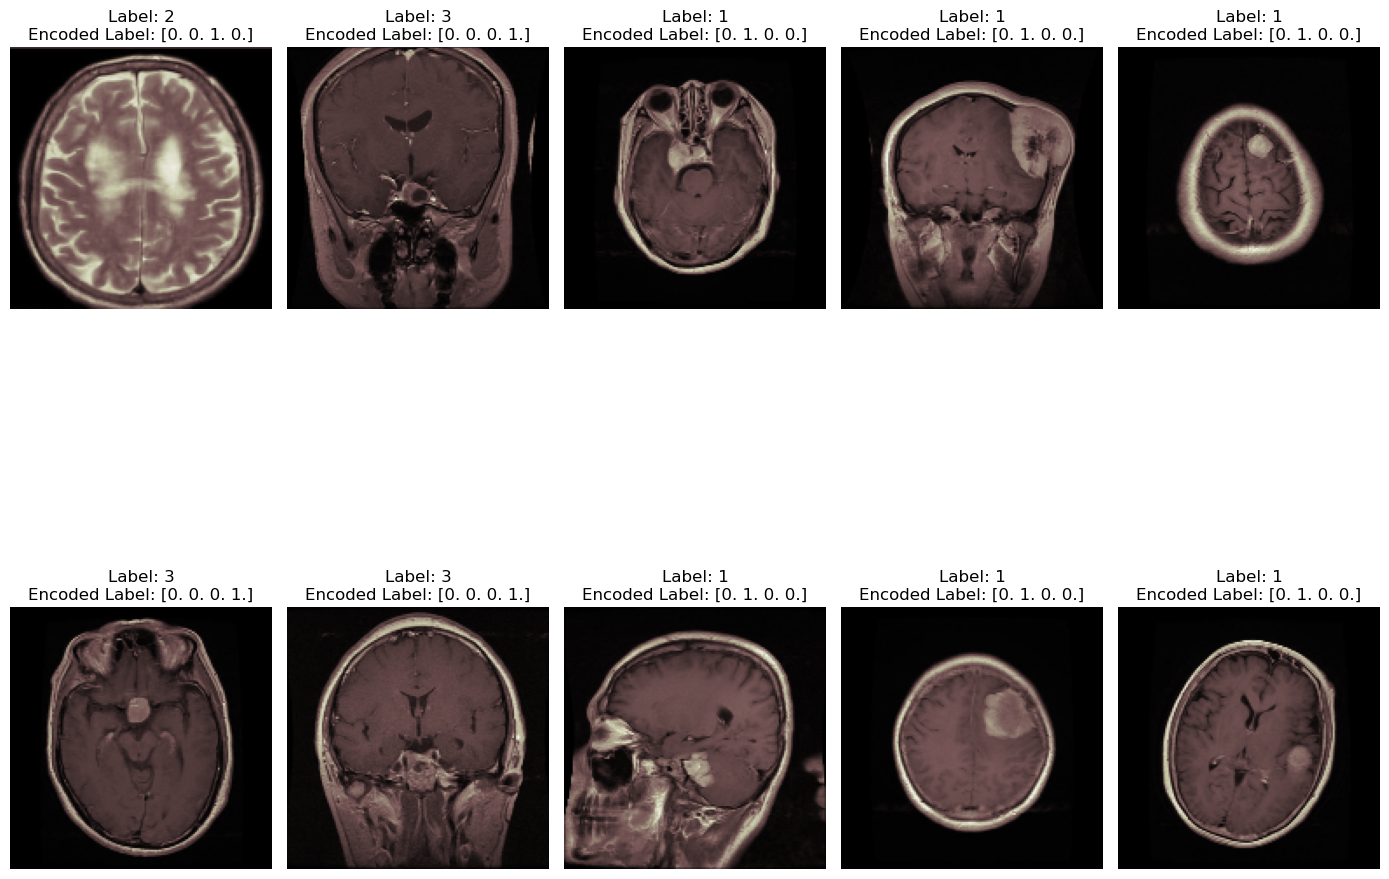

In [5]:
images = [X[i] for i in range(10)]
labels = [Y[i] for i in range(10)]
encoded_labels = [Y_encoded[i] for i in range(10)]

fig, axes = plt.subplots(2, 5, figsize=(14, 14))
axes = axes.flatten()

for img, label, encoded_label, ax in zip(images, labels, encoded_labels, axes):
    ax.imshow(img)
    ax.set_title(f"Label: {label}\nEncoded Label: {encoded_label}")
    ax.axis("off")

plt.tight_layout()
plt.show()

### Train and test split

In [6]:
x_train, x_test, y_train, y_test = train_test_split(X, Y_encoded, test_size = 0.2, random_state = 105)

print ('x_train: ', x_train.shape)
print ('x_test: ', x_test.shape)
print ('y_train: ', y_train.shape)
print ('y_test: ', y_test.shape)

x_train:  (2611, 150, 150, 3)
x_test:  (653, 150, 150, 3)
y_train:  (2611, 4)
y_test:  (653, 4)


### Neural network

In [7]:
def cnn_model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(4, activation='softmax'))
    
    return model


In [8]:
# Build and compile model
model = cnn_model()
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'Adam',
    metrics = ['accuracy', metrics.AUC(), metrics.Precision(), metrics.Recall(), metrics.MeanIoU(num_classes=4)]
)

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [9]:
history = model.fit(x_train, y_train, epochs = 50, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/50
82/82 [==============================] - 8s 36ms/step - loss: 1.1242 - accuracy: 0.5013 - auc: 0.7727 - precision: 0.6061 - recall: 0.2375 - mean_io_u: 0.3750 - val_loss: 0.9153 - val_accuracy: 0.6080 - val_auc: 0.8639 - val_precision: 0.6398 - val_recall: 0.5712 - val_mean_io_u: 0.3750
Epoch 2/50
82/82 [==============================] - 2s 22ms/step - loss: 0.7743 - accuracy: 0.6902 - auc: 0.8961 - precision: 0.7448 - recall: 0.6136 - mean_io_u: 0.3750 - val_loss: 0.6162 - val_accuracy: 0.7397 - val_auc: 0.9326 - val_precision: 0.7763 - val_recall: 0.7014 - val_mean_io_u: 0.3750
Epoch 3/50
82/82 [==============================] - 2s 22ms/step - loss: 0.5156 - accuracy: 0.8031 - auc: 0.9532 - precision: 0.8335 - recall: 0.7671 - mean_io_u: 0.3750 - val_loss: 0.4825 - val_accuracy: 0.7887 - val_auc: 0.9588 - val_precision: 0.8058 - val_recall: 0.7688 - val_mean_io_u: 0.3750
Epoch 4/50
82/82 [==============================] - 2s 21ms/step - loss: 0.3711 - accuracy: 0.8686 - au

### Metrics


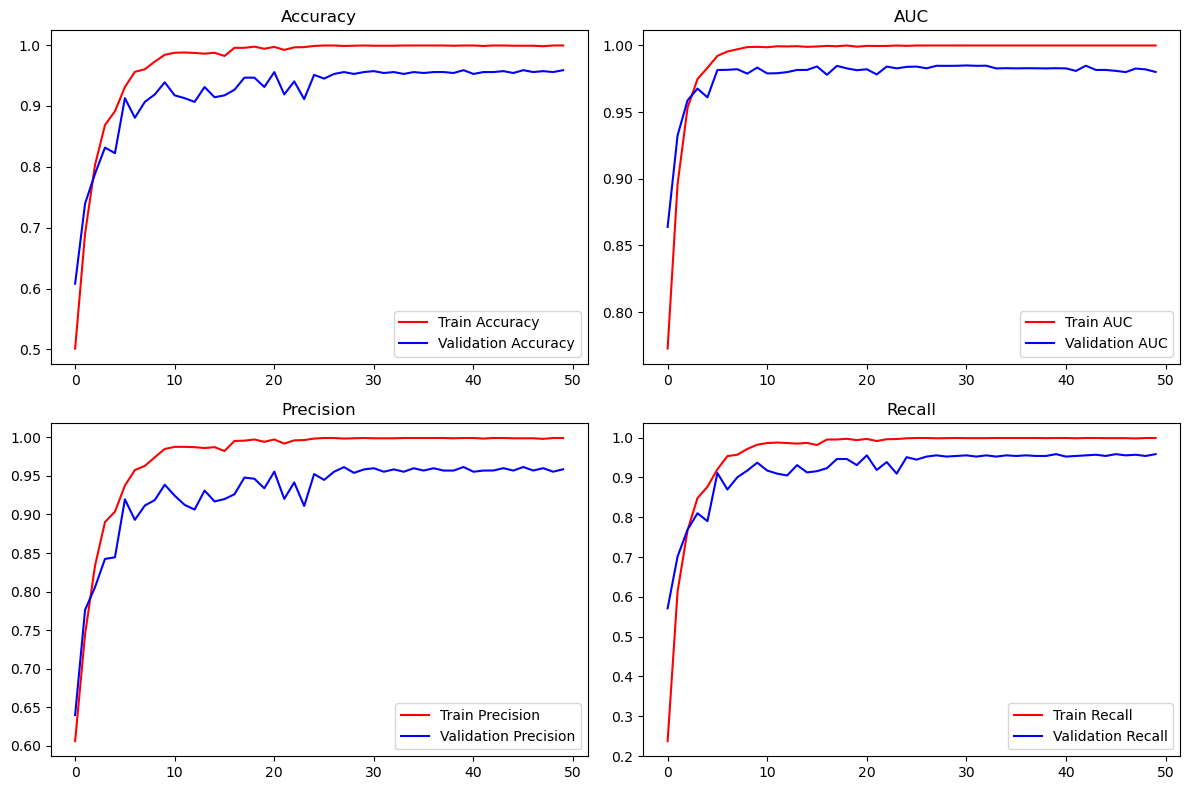

In [10]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_auc = history.history['auc']
val_auc = history.history['val_auc']

train_precision = history.history['precision']
val_precision = history.history['val_precision']

train_recall = history.history['recall']
val_recall = history.history['val_recall']

train_mean_iou = history.history['mean_io_u']
val_mean_iou = history.history['val_mean_io_u']

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
epochs = range(len(train_accuracy))

# Plot accuracy
axs[0, 0].plot(epochs, train_accuracy, 'r', label='Train Accuracy')
axs[0, 0].plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
axs[0, 0].set_title('Accuracy')
axs[0, 0].legend(loc='lower right')

# Plot AUC
axs[0, 1].plot(epochs, train_auc, 'r', label='Train AUC')
axs[0, 1].plot(epochs, val_auc, 'b', label='Validation AUC')
axs[0, 1].set_title('AUC')
axs[0, 1].legend(loc='lower right')

# Plot precision
axs[1, 0].plot(epochs, train_precision, 'r', label='Train Precision')
axs[1, 0].plot(epochs, val_precision, 'b', label='Validation Precision')
axs[1, 0].set_title('Precision')
axs[1, 0].legend(loc='lower right')

# Plot recall
axs[1, 1].plot(epochs, train_recall, 'r', label='Train Recall')
axs[1, 1].plot(epochs, val_recall, 'b', label='Validation Recall')
axs[1, 1].set_title('Recall')
axs[1, 1].legend(loc='lower right')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [11]:
print(f'Final accuracy: {val_accuracy[-1] * 100}')

Final accuracy: 95.86523771286011


### Prediction

In [12]:
def final_prediction(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (150,150))
    img_array = np.array(img)
    img_array = img_array.reshape(1,150,150,3)
    a = model.predict(img_array) # a is the probability array
    indices = a.argmax()
    labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
    return labels[indices]

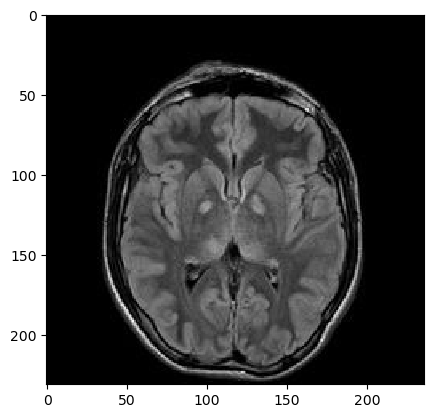

In [13]:
img_path = '/kaggle/input/brain-tumor-classification-mri/Testing/no_tumor/image(24).jpg'
img = image.load_img(img_path)
plt.imshow(img,interpolation = 'nearest')
plt.show()

In [14]:
predicted_class = final_prediction(img_path)
predicted_class

1/1 [==============================] - 0s 179ms/step


'no_tumor'

### Save model parameters

In [15]:
# Convert and save the model in TensorFlow.js format
tfjs.converters.save_keras_model(model, 'model_js')

In [16]:
# Get the model architecture as a JSON string
'''
model_json = model.to_json()

# Save the model architecture to a JSON file
with open('model_architecture.json', 'w') as json_file:
    json_file.write(model_json)
'''

"\nmodel_json = model.to_json()\n\n# Save the model architecture to a JSON file\nwith open('model_architecture.json', 'w') as json_file:\n    json_file.write(model_json)\n"